# 3D pitch angle scatter SDE by midpoint method

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import ipyparallel as ipp
from mpl_toolkits.mplot3d import Axes3D

# use latex in the notebook. Might casue trouble if pc do not have such latex packages
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsfonts} \usepackage{amsmath} \usepackage{bm}')

# generate high quality figures in notebook
%config InlineBackend.figure_format = 'retina'

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Our equation is:
\begin{align}
    \mathrm{d} {v} 
    = \left(I-\dfrac{{vv}}{v^2}\right) \circ \mathrm{d}{\boldsymbol{\mathcal{W}}}, 
    \label{SDE}
\end{align}

For simplicity, change the equation to:
\begin{align}
    \mathrm{d}v 
    = \dfrac{1}{v_0^2}\left(\boldsymbol{v}\cdot\boldsymbol{v}-\boldsymbol{vv}\right) \circ \mathrm{d}{\boldsymbol{\mathcal{W}}}
\end{align}

Using midpoint rule, the discretization is:
\begin{align}
v_{n+1} - v_n &= \left(\dfrac{v_{n+1/2}^2-v_{n+1/2}v_{n+1/2}}{v_0^2}\right) \Delta{\hat{W}}
\end{align}

Written in components, have:
\begin{align}
    \begin{pmatrix} v_{n+1,x} \\  v_{n+1,y} \\  v_{n+1,z} \end{pmatrix} = 
    \begin{pmatrix} v_{n,x} \\  v_{n,y} \\  v_{n,z} \end{pmatrix}
    + \dfrac{1}{v_{0,x}^2+v_{0,y}^2+v_{0,z}^2}
    \begin{pmatrix}
    v_{n+1/2,y}^2 + v_{n+1/2,z}^2 & -v_{n+1/2,x} v_{n+1/2,y} & -v_{n+1/2,x} v_{n+1/2,z} \\
    -v_{n+1/2,y} v_{n+1/2,x} & v_{n+1/2,x}^2 + v_{n+1/2,z}^2 & -v_{n+1/2,y} v_{n+1/2,z} \\
    -v_{n+1/2,z} v_{n+1/2,x} & -v_{n+1/2,z} v_{n+1/2,y} & v_{n+1/2,x}^2 + v_{n+1/2,y}^2
    \end{pmatrix}
    \begin{pmatrix}
        \Delta \hat{W}_x \\ \Delta \hat{W}_y \\ \Delta \hat{W}_z
    \end{pmatrix},
\end{align}

where:

\begin{align}
\Delta \hat{W} =  \zeta_{h} \sqrt{\Delta t}, \quad v_{n+1/2} = \dfrac{1}{2}(v_n+v_{n+1})
\end{align}

In this calculation, we choose $v_{0,x}^2+v_{0,y}^2 = 1$ for simplicity.

## Implicit solver

Let the implicit equation we want to solve be $F$:
\begin{align}
F(v_{n+1}) := 
    \begin{pmatrix} v_{n+1,x} \\  v_{n+1,y} \\  v_{n+1,z} \end{pmatrix} -
    \begin{pmatrix} v_{n,x} \\  v_{n,y} \\  v_{n,z} \end{pmatrix}
    - \begin{pmatrix}
    v_{n+1/2,y}^2 + v_{n+1/2,z}^2 & -v_{n+1/2,x} v_{n+1/2,y} & -v_{n+1/2,x} v_{n+1/2,z} \\
    -v_{n+1/2,y} v_{n+1/2,x} & v_{n+1/2,x}^2 + v_{n+1/2,z}^2 & -v_{n+1/2,y} v_{n+1/2,z} \\
    -v_{n+1/2,z} v_{n+1/2,x} & -v_{n+1/2,z} v_{n+1/2,y} & v_{n+1/2,x}^2 + v_{n+1/2,y}^2
    \end{pmatrix}
    \begin{pmatrix}
        \Delta \hat{W}_x \\ \Delta \hat{W}_y \\ \Delta \hat{W}_z
    \end{pmatrix},
\end{align}

The corresponding Jocobi matrix is:
\begin{align}
J := \dfrac{\partial F}{ \partial v_{n+1}} = 
\begin{pmatrix}
1 + \dfrac{1}{2} \left( v_{n+1/2,y} \Delta \hat{W}_y  + v_{n+1/2,z} \Delta \hat{W}_z \right) & 
- v_{n+1/2,y}  \Delta \hat{W}_x + \dfrac{1}{2} v_{n+1/2,x} \Delta \hat{W}_y & 
- v_{n+1/2,z}  \Delta \hat{W}_x + \dfrac{1}{2} v_{n+1/2,x} \Delta \hat{W}_z \\[10pt]
- v_{n+1/2,x}  \Delta \hat{W}_y + \dfrac{1}{2} v_{n+1/2,y} \Delta \hat{W}_x &
1 + \dfrac{1}{2} \left( v_{n+1/2,x} \Delta \hat{W}_x  + v_{n+1/2,z} \Delta \hat{W}_z \right) & 
- v_{n+1/2,z}  \Delta \hat{W}_y + \dfrac{1}{2} v_{n+1/2,y} \Delta \hat{W}_z \\[10pt]
- v_{n+1/2,x}  \Delta \hat{W}_z + \dfrac{1}{2} v_{n+1/2,z} \Delta \hat{W}_x &
- v_{n+1/2,y}  \Delta \hat{W}_z + \dfrac{1}{2} v_{n+1/2,z} \Delta \hat{W}_y & 
1 + \dfrac{1}{2} \left( v_{n+1/2,x} \Delta \hat{W}_x  + v_{n+1/2,y} \Delta \hat{W}_y \right)
\end{pmatrix}
\end{align}

Assume at the 0th iteration, we have:
\begin{align}
    \begin{pmatrix} v^{(0)}_{n+1,x} \\  v^{(0)}_{n+1,y} \\  v^{(0)}_{n+1,z} \end{pmatrix} = 
    \begin{pmatrix} v_{n,x} \\  v_{n,y} \\  v_{n,z} \end{pmatrix}
    + \begin{pmatrix}
    v_{n,y}^2 + v_{n,z}^2 & -v_{n,x} v_{n,y} & -v_{n,x} v_{n,z} \\
    -v_{n,y} v_{n,x} & v_{n,x}^2 + v_{n,z}^2 & -v_{n,y} v_{n,z} \\
    -v_{n,z} v_{n,x} & -v_{n,z} v_{n,y} & v_{n,x}^2 + v_{n,y}^2
    \end{pmatrix}
    \begin{pmatrix}
        \Delta \hat{W}_x \\ \Delta \hat{W}_y \\ \Delta \hat{W}_z
    \end{pmatrix},
\end{align}

Then the iteration becomes:

\begin{align}
\begin{pmatrix} v^{(k+1)}_{n+1,x} \\  v^{(k+1)}_{n+1,y} \\  v^{(k+1)}_{n+1,z} \end{pmatrix} = 
\begin{pmatrix} v^{(k)}_{n+1,x} \\  v^{(k)}_{n+1,y} \\  v^{(k)}_{n+1,z} \end{pmatrix} 
- J\left(v^{(k)}_{n+1,x}, v^{(k)}_{n+1,y}, v^{(k)}_{n+1,z}\right)^{-1} F\left(v^{(k)}_{n+1,x}, v^{(k)}_{n+1,y}, v^{(k)}_{n+1,z}\right)
\end{align}

In [150]:
# start parallel computing, using ipyparallel
# need to run the cmd `ipcluster start -n X` in terminal, here X is the number of cores
rc = ipp.Client()
print(rc.ids)
n_core = len(rc.ids)
dview = rc[:]

[0, 1, 2, 3, 4, 5]


In [151]:
# Basic parameters
l_max = 10
dt_min = 1./(2.**l_max) # minimum time step, dt_min = 2^{-l_max} 
T = 1. # total time
L_max = int(T/dt_min)  # max number of steps
M = 10000  # number of different Wiener processes
M_per_core = int(M/n_core)  # number of different Winer process per core
v_0 = np.array([1.0,0,0]) # initial velocity
N_newton = 2 # number of Newton iteration

# create a dict to easily transmit to each core.
basic_parameters = dict(
l_max = l_max, 
dt_min = dt_min, 
T = T,
L_max = L_max,
M = M,
M_per_core = M_per_core,
v_0 = v_0,
N_newton = N_newton
)

In [119]:
# define function F. v0:= v_n, v1:= v_{n+1}, v:= v_{n+1/2}, dw := \Delta \hat{W}
def mid_point_F( vx0, vy0, vz0, vx1, vy1, vz1, dwx, dwy, dwz ):
    
    # calculate the mid point
    vx = (vx0 + vx1) / 2.
    vy = (vy0 + vy1) / 2.
    vz = (vz0 + vz1) / 2.
    
    # calculate vx_2 := v_{n+1/2,x}^2, v_2 := v_{n+1/2,x}^2 + v_{n+1/2,y}^2, v_cross := v_{n+1/2,x} * v_{n+1/2,y}
    vx_2 = vx**2.
    vy_2 = vy**2.
    vz_2 = vz**2.
    
    v_2 = vx_2 + vy_2 + vz_2
    v_xy = vx * vy
    v_xz = vx * vz 
    v_yz = vy * vz
    
    return np.array([ vx1-vx0, vy1-vy0, vz1-vz0 ]) - np.array([ (vy_2+vz_2)*dwx - v_xy*dwy - v_xz*dwz, 
                                                               - v_xy*dwx + (vx_2+vz_2)*dwy - v_yz*dwz,
                                                               - v_xz*dwx - v_yz*dwy + (vx_2+vy_2)*dwz])


# define the Jacobi matrix
def mid_point_J( vx0, vy0, vz0, vx1, vy1, vz1, dwx, dwy, dwz ):
    
    # define mid point
    vx = (vx0 + vx1) / 2.
    vy = (vy0 + vy1) / 2.
    vz = (vz0 + vz1) / 2.
    
    # define xx := v_{n+1/2,x} * \Delta \hat{W}_x, etc.
    xx = vx * dwx
    xy = vx * dwy
    xz = vx * dwz
    yx = vy * dwx
    yy = vy * dwy
    yz = vy * dwz
    zx = vz * dwx
    zy = vz * dwy
    zz = vz * dwz
    
    return np.array([[ 1. + (yy+zz) / 2.,      - yx + xy / 2.,      - zx + xz / 2. ],
                     [ - xy + yx / 2.,      1. + (xx+zz) / 2.,      - zy + yz / 2. ],
                     [ - xz + zx / 2.,      - yz + zy / 2.,      1. + (xx+yy) / 2. ]])


# define the Newton iteration, N: number of iteration
# here vx0 := v_{n,x}, etc
def mid_point_Newton( vx0, vy0, vz0, dwx, dwy, dwz, N ):
    
    # calculate vx_2 := v_{n,x}^2, v_2 := v_{n,x}^2 + v_{n,y}^2, v_cross := v_{n,x} * v_{n,y}
    vx_2 = vx0**2.
    vy_2 = vy0**2.
    vz_2 = vz0**2.
    
    v_xy = vx0 * vy0
    v_xz = vx0 * vz0 
    v_yz = vy0 * vz0
    
    # give the inital guess, v^{(0)}
    ( vx_new, vy_new, vz_new ) = np.array([vx0, vy0, vz0]) + np.array([ (vx_2+vy_2)*dwx - v_xy*dwy - v_xz*dwz, 
                                                                       - v_xy*dwx + (vx_2+vz_2)*dwy - v_yz*dwz,
                                                                       - v_xz*dwx - v_yz*dwy + (vx_2+vy_2)*dwz])
    
    # begin iteration:
    for i in range(N):
        
        vx_old = vx_new
        vy_old = vy_new
        vz_old = vz_new
        
        (vx_new, vy_new, vz_new) = np.array([vx_old, vy_old, vz_old]) - np.matmul( \
                              np.linalg.inv(mid_point_J( vx0, vy0, vz0, vx_old, vy_old, vz_old, dwx, dwy, dwz )), \
                                        mid_point_F( vx0, vy0, vz0, vx_old, vy_old, vz_old, dwx, dwy, dwz ) )
        
    
    return np.array([vx_new, vy_new, vz_new])

# the dict of functions, to be pushed to each core.
basic_func = dict(
mid_point_F = mid_point_F,
mid_point_J = mid_point_J,
mid_point_Newton = mid_point_Newton
)

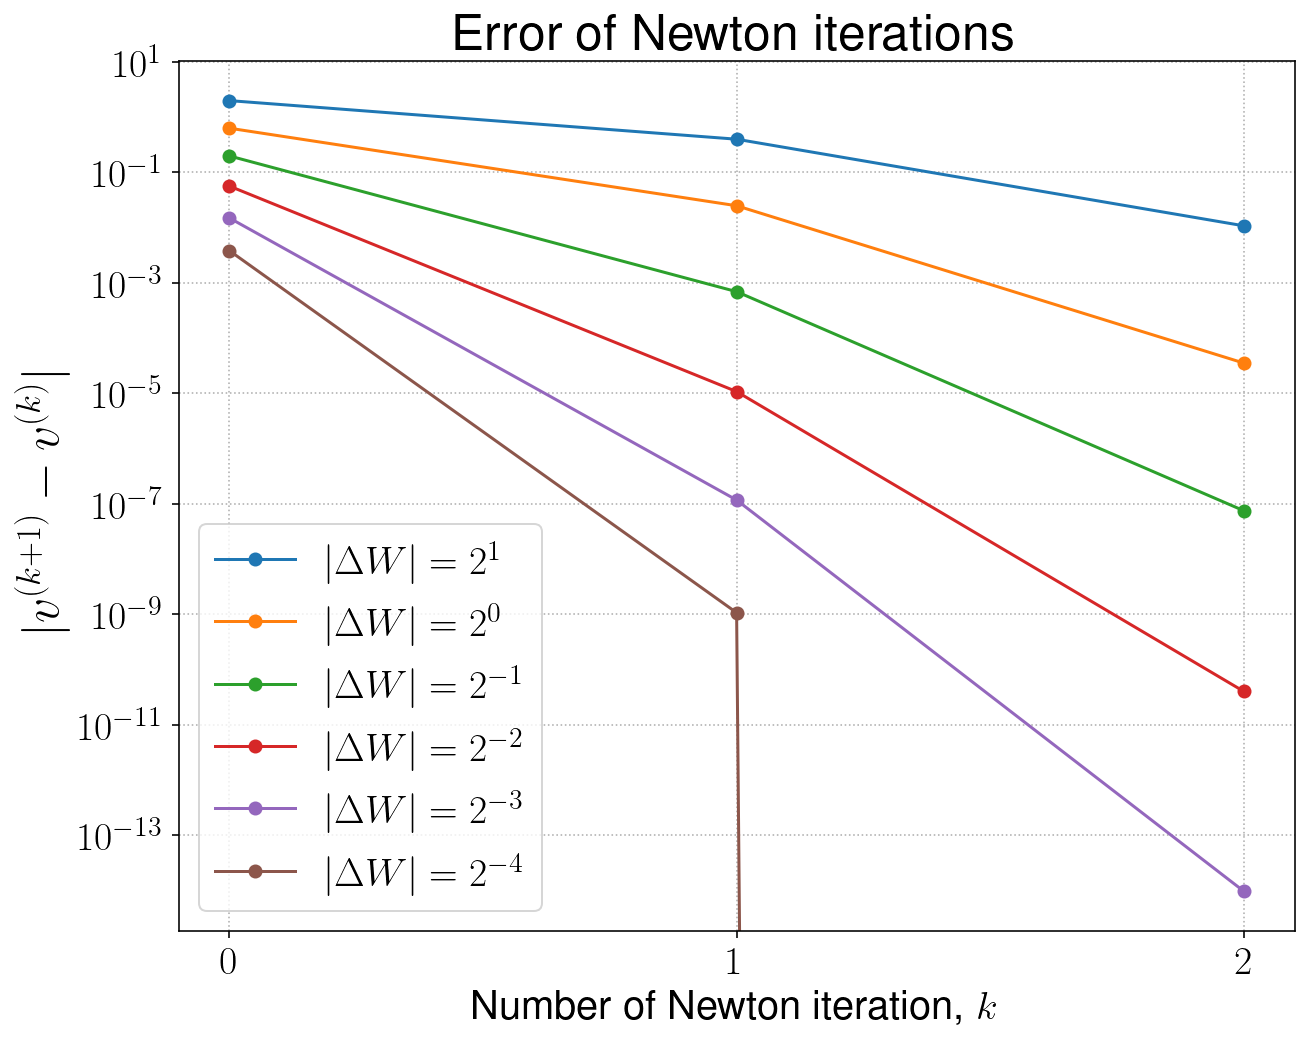

In [45]:
# test Newton iteration
plt.figure(figsize=(10,8))

vx0 = 0; vy0 = 1; vz0 = 1; dwx = 0.; dwz = 0;

for j in [1,0,-1,-2,-3,-4]:
    
    dwy = 2.**j

    error = np.zeros((3))

    for i in range(3):

        delta = mid_point_Newton( vx0, vy0, vz0, dwx, dwy, dwz, i) \
                - mid_point_Newton( vx0, vy0, vz0, dwx, dwy, dwz, i+1)
        error[i] = np.sqrt( delta[0]**2 + delta[1]**2 )

    plt.plot(np.arange(3), error, marker='o', label = '$|\Delta W| = 2^{%i}$' % j)
    
plt.grid(which='both',linestyle=':')
plt.legend(fontsize=20)
plt.yscale('log')
plt.xlabel('Number of Newton iteration, $k$', fontsize=20); plt.xticks([0,1,2],fontsize=20);
plt.ylabel(r'$|v^{(k+1)} - v^{(k)}|$',fontsize=25); plt.yticks(fontsize=20);
plt.title('Error of Newton iterations', fontsize = 25);

# save fig
plt.savefig('./fig/3DMP_error_newton.pdf')

In [46]:
# define the evolution based on mid point rule
def Mid_point():
    
    # import package for each core
    global np
    import numpy as np

    # calculate the result for M different Wiener processes with l_max different time steps.
    np.random.seed(random_seed)

    # The final results are saved in one dict.
    MP = {}

    # Go through all M different Wiener processes
    for i in range(M_per_core):

        # pick up a Wiener process
        dw_x = np.random.normal(0,np.sqrt(dt_min),L_max)
        dw_y = np.random.normal(0,np.sqrt(dt_min),L_max)
        dw_z = np.random.normal(0,np.sqrt(dt_min),L_max)

        # initalize the sub-dict for this Wiener process
        MP[i] = {}

        # go through different time step
        for l in range(l_max+1):

            # initial the sub-dict for this time step
            MP[i][l] = {}

            # build up the Weiner process for this particular time step, dt = 2^{-l}
            dt = 2.**(-l)
            k = 2**(l_max-l)
            L = int(L_max / k)
            dw_x_2 = np.sum(np.reshape(dw_x,(L, k)),axis=1)
            dw_y_2 = np.sum(np.reshape(dw_y,(L, k)),axis=1)
            dw_z_2 = np.sum(np.reshape(dw_z,(L, k)),axis=1)
            
            # truncate the normal distribution to avoid blowing up
            A = np.sqrt(4. * np.abs(np.log(dt)))
            dw_x_2[np.where(dw_x_2>A)]=A
            dw_x_2[np.where(dw_x_2<-A)]=-A
            dw_y_2[np.where(dw_y_2>A)]=A
            dw_y_2[np.where(dw_y_2<-A)]=-A
            dw_z_2[np.where(dw_z_2>A)]=A
            dw_z_2[np.where(dw_z_2<-A)]=-A

            # initialize the data set for v_x and v_y
            vx = np.zeros(L+1)
            vy = np.zeros(L+1)
            vz = np.zeros(L+1)

            vx[0] = v_0[0]
            vy[0] = v_0[1]
            vz[0] = v_0[2]

            # go through each step with dt = 2^{-l}, total step is L
            for j in range(L):

                # calculate equation
                ( vx[j+1], vy[j+1], vz[j+1] ) \
                = mid_point_Newton( vx[j], vy[j], vz[j], dw_x_2[j], dw_y_2[j], dw_z_2[j], N_newton )


            # save the result into dict
            # for the first one, save the whole path;
            # for others, only save the final result
            if  i == 0:
                MP[i][l]['vx'] = vx
                MP[i][l]['vy'] = vy
                MP[i][l]['vz'] = vz
                MP[i][l]['t'] = np.arange(0,T+dt,dt)
            else:
                MP[i][l]['vx'] = vx[-1]
                MP[i][l]['vy'] = vy[-1]
                MP[i][l]['vz'] = vz[-1]
                
    return MP

In [138]:
# Send the constants and functions to each core
dview.push(basic_parameters)
dview.push(basic_func)

# Set different random seeds for each core
dview.scatter('random_seed',np.arange(n_core))

# run in parallel
t1 = time.time()
MP_results = dview.apply(Mid_point).get()
t2 = time.time()
print(t2-t1)

# save the result to file
with open('../data/3DMP.pickle', 'wb') as handle:
    pickle.dump(MP_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

16.296653985977173


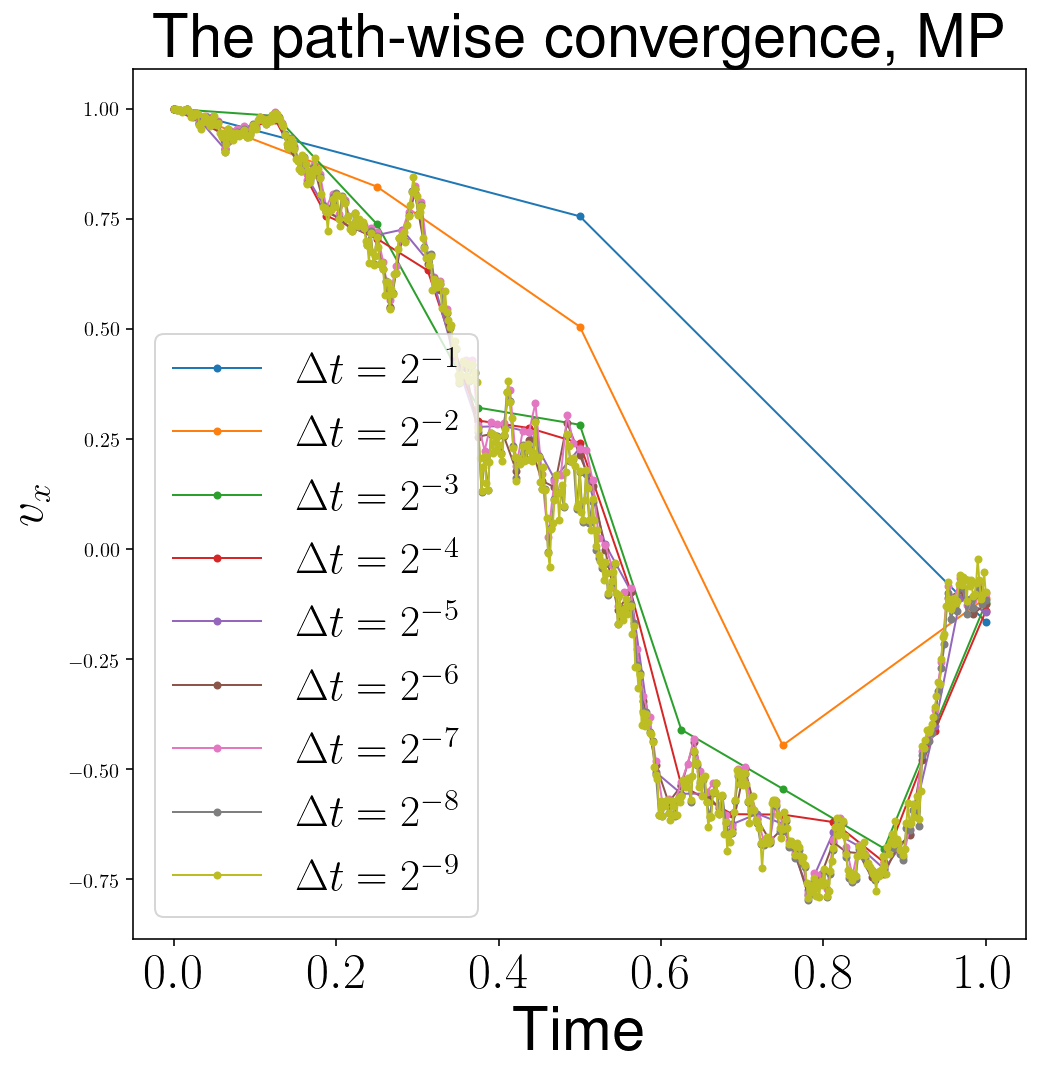

In [139]:
# path-wise

MP = MP_results[0]

# calculation of pathwise convergent.
plt.figure(figsize=(8,8))
for l in range(1,l_max):
    plt.plot(MP[0][l]['t'], MP[0][l]['vx'], label='$\Delta t = 2^{-%i}$' % l, \
             marker='o', markersize=3, linewidth=1)
    
plt.legend(fontsize=22);plt.xticks(fontsize=25);
# plt.yticks([-1, -0.5,0,0.5,1],fontsize=20);
plt.title('The path-wise convergence, MP', fontsize=30);
plt.xlabel('Time',fontsize=30); plt.ylabel('$v_x$',fontsize=25);

# save fig
plt.savefig('./fig/3DMP_path_wise.pdf')

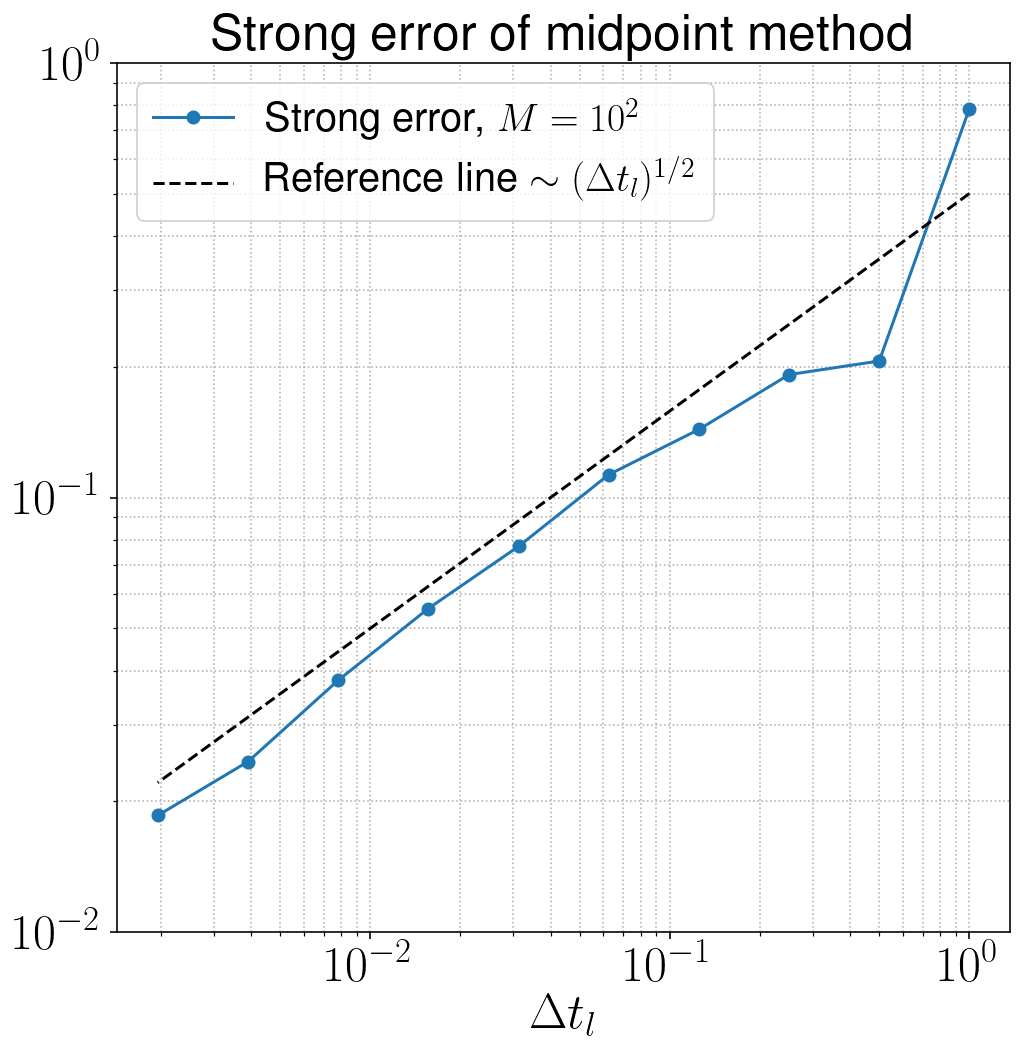

In [146]:
# calculate the stong convergence based on the result MP.
plt.figure(figsize=(8,8))

# initialize the result of strong convergence
dt_list = np.array([ 2.**(-l) for l in range(l_max) ])

# create a reference line for order 1/2 convergence
ref = np.array([ 0.5*dt**(0.5) for dt in dt_list ])

# test the result for different number of particles
for M_max in [100]:
    
    # initialize 
    e_strong = np.zeros((l_max))

    # go through all dt = 2^{-l}   
    for l in np.arange(l_max):
        
        epsilon = 0.
        count = 0

        # go through all independent processes
        for alpha in range(n_core):

            MP = MP_results[alpha]

            for i in range(1,M_per_core):
                
                # only calculate M < M_max
                count += 1
                if count > M_max:
                    break

                epsilon += np.sqrt( (MP[i][l]['vx'] - MP[i][l+1]['vx'])**2 \
                                   + (MP[i][l]['vy'] - MP[i][l+1]['vy'])**2 \
                                   + (MP[i][l]['vz'] - MP[i][l+1]['vz'])**2)

        e_strong[l] = epsilon / M_max

    # plot the data
    plt.plot(dt_list,e_strong,marker='o', label='Strong error, $M= 10^{%i}$' % np.log10(M_max))

# settings for the figure
plt.plot(dt_list,ref, color='k', linestyle='--', label='Reference line $\sim (\Delta t_l)^{1/2}$')
plt.xscale('log'); plt.yscale('log'); plt.legend(fontsize=20);
plt.ylim([1e-2,1]); 
plt.grid(which='both',linestyle=':')
plt.xticks(fontsize=25);plt.yticks(fontsize=25);
plt.xlabel('$\Delta t_l$',fontsize=25);
# plt.ylabel(r'$\mathbb{E}\left|X_{T}^{\Delta t_{l+1}} - X_{T}^{\Delta t_{l}}\right|$',fontsize=20);
plt.title('Strong error of midpoint method', fontsize=25);

# save fig
plt.savefig('./fig/3DMP_strong.pdf')

In [152]:
# test number of Newton
MP_newton = {}

# use fewer particles
M = 10000  # number of different Wiener processes
M_per_core = int(M/n_core)  # number of different Winer process per core

for N_newton in [1,2,3]:

    # create a dict to easily transmit to each core.
    basic_parameters = dict(
    l_max = l_max, 
    dt_min = dt_min, 
    T = T,
    L_max = L_max,
    M = M,
    M_per_core = M_per_core,
    v_0 = v_0,
    N_newton = N_newton
    )

    # Send the constants and functions to each core
    dview.push(basic_parameters)
    dview.push(basic_func)

    # Set different random seeds for each core
    dview.scatter('random_seed',np.arange(n_core))

    # run in parallel
    t1 = time.time()
    MP_newton[N_newton] = dview.apply(Mid_point).get()
    t2 = time.time()
    print(t2-t1)

# save the result to file
with open('../data/3DMP_Newton.pickle', 'wb') as handle:
    pickle.dump(MP_newton, handle, protocol=pickle.HIGHEST_PROTOCOL)

441.3290259838104
895.1789100170135
1278.9154720306396


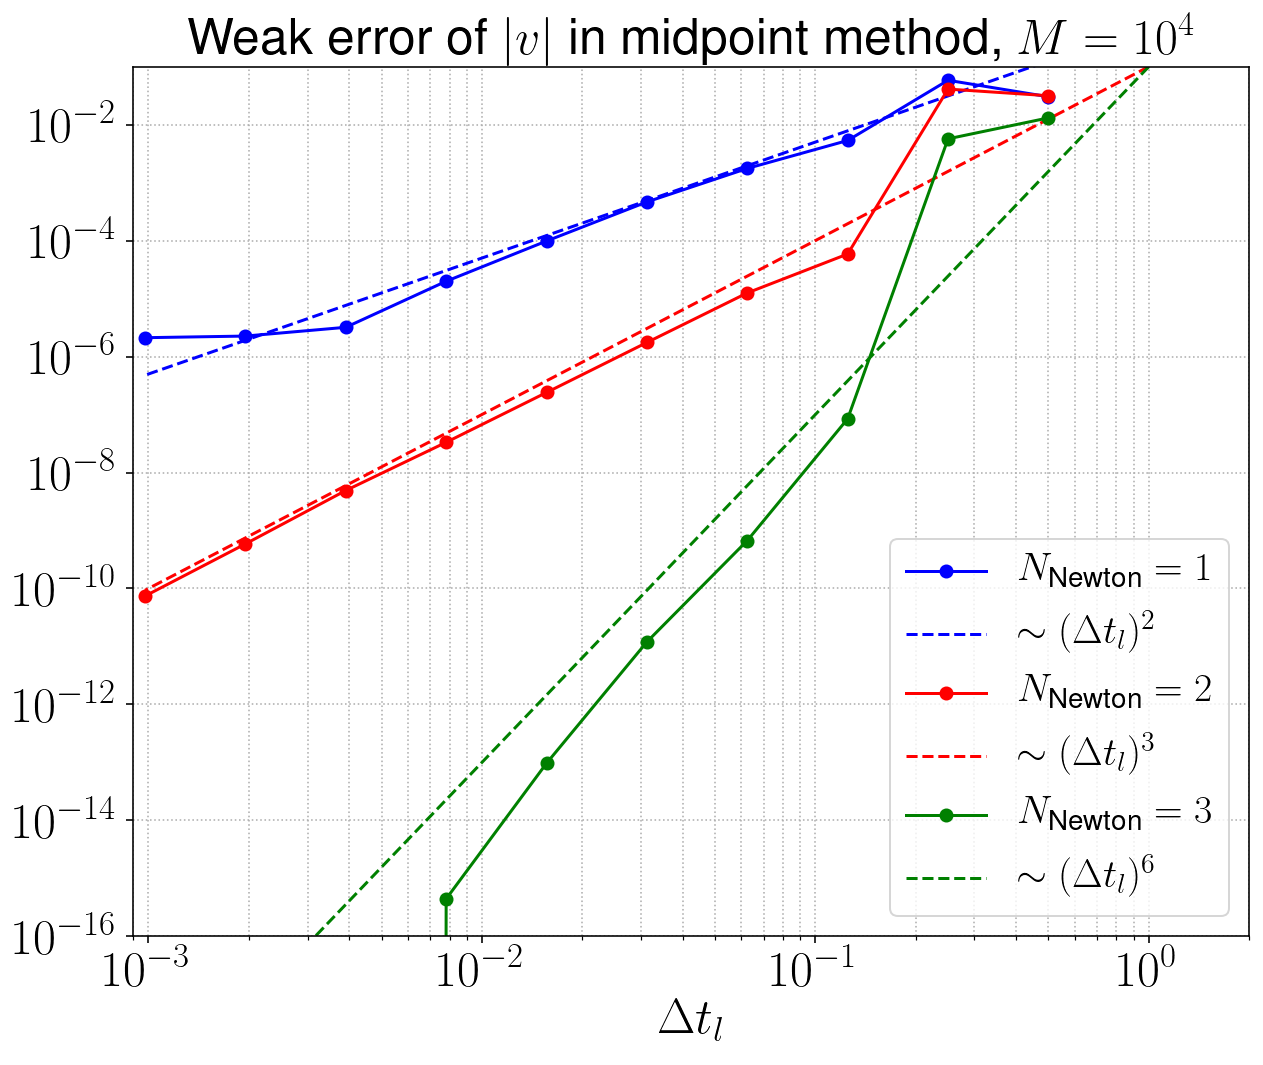

In [158]:
# calculate the weak error of |v| in MP
plt.figure(figsize=(10,8))

color_list = ['b','r','g']
coef = [0.5, 1e-1, 0.1]
order = [2, 3, 6]

dt_list = np.array([ 2.**(-l) for l in range(l_max+1) ])

for N_newton in [1,2,3]:

    for M_max in [M]:

        # initialize the weak error and expectation of all dt^l
        e_weak = np.zeros((l_max+1))
        Ev = np.zeros((l_max+1))

        # go through all dt = 2^{-l} to calculate expectation
        for l in np.arange(l_max+1):
            v_magnitude= 0.
            count = 0

            # go through all independent processes
            for alpha in range(n_core):
                MP = MP_newton[N_newton][alpha]

                for i in range(1,M_per_core):

                    if count > M_max:
                        break
                    
                    v_magnitude += np.sqrt( MP[i][l]['vx']**2. + MP[i][l]['vy']**2. + MP[i][l]['vz']**2. )
                    count += 1

            # averaging
            Ev[l] = v_magnitude / count

        # calculate weak error
        for l in np.arange(l_max+1):
            e_weak[l] = np.abs( Ev[l] - 1. )

        plt.plot(dt_list[1:], e_weak[1:], marker='o', color=color_list[N_newton-1], \
                 label=r'$N_{\text{Newton}}=%i$' % N_newton)
        
        # create a reference line for order 5 convergence
        ref = np.array([ coef[N_newton-1] * dt**order[N_newton-1] for dt in dt_list ])
        plt.plot(dt_list,ref, color=color_list[N_newton-1] , linestyle='--', \
                 label='$\sim (\Delta t_l)^{%i}$' % order[N_newton-1])

# settings for the figure
plt.xlim([0.9e-3,2])
plt.ylim([1e-16,0.1]);
plt.xscale('log'); plt.yscale('log'); plt.legend(fontsize=20);
plt.grid(which='both',linestyle=':')
plt.xticks(fontsize=25);plt.yticks(fontsize=25);
plt.xlabel('$\Delta t_l$',fontsize=25);
# plt.ylabel(r'$\left|\mathbb{E} \left| v_{T}^{\Delta t_{l}} \right| -  |v_0| \right|$',fontsize=20);
plt.title('Weak error of $|v|$ in midpoint method, $M=10^4$', fontsize=25);

# save fig
plt.savefig('./fig/3DMP_v_weak_newton.pdf')